Training notebook for the deeptail task without data augmentation

In [1]:
import tensorflow
import keras
keras.__version__

Using TensorFlow backend.


'2.1.2'

## Getting started 
- Download data from: https://www.kaggle.com/c/whale-categorization-playground
- Rename train.csv to targets.csv
- Rename the train directory to kaggle_train


In [2]:
import os

home_dir = os.getcwd()
fname = os.path.join(home_dir, 'targets.csv') # targets for both train and validation

f = open(fname)
data = f.read()
f.close()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
lines = lines[:-1]

print(header)
print(len(lines))

['Image', 'Id']
9850


# Encoding the whale ids


In [3]:
import numpy as np
whale_ids = [line.split(',')[1] for line in lines]
whale_ids = set(whale_ids) # convert to set to remove duplicats
whale_ids = list(whale_ids) # convert back to list to make it ordered
whale_ids.remove('new_whale') # remove the new_whale since we will not train with this

print(len(whale_ids))

4250


# Preprocessing images

In [5]:
import errno 

def mkdir_p(path):
    try:
        os.makedirs(path)
    except OSError as exc:  
        if exc.errno == errno.EEXIST and os.path.isdir(path):
            pass
        else:
            raise

Split the training images into a train and validation set, and then subdivide them into directories for each whale_id

In [6]:
import shutil
original_dataset_dir = os.path.join(home_dir, 'kaggle_train')

train_dir = os.path.join(home_dir, 'train')
#shutil.rmtree(train_dir)
mkdir_p(train_dir)

validation_dir = os.path.join(home_dir, 'validation')
#shutil.rmtree(validation_dir)
mkdir_p(validation_dir)

# Let's then create a subdirectory for each whale_id in both the train and validation directories 
# so we can use the ImageDataGenerator magic function

classes_count = len(whale_ids) # During the development phase of testing models, we dont look at all 4251 classes. 
                     # When we're ready to look at all classes we can set classes_count = len(whale_ids)

for i, whale_id in enumerate(whale_ids):
    if i < classes_count:
        mkdir_p(os.path.join(train_dir, whale_id))
        mkdir_p(os.path.join(validation_dir, whale_id))

train_image_count = 0

# Copy first 7500 files into the appropriate whale directory in train dir (only if their class is included)   
for i in range(9500):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(train_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        train_image_count += 1

validation_image_count = 0
# copy the rest into the appropriate whale directory in validation dir    (only if their class is included)  
for i in range(9500,len(lines)):
    pic = lines[i].split(',')[0]
    whale_id = lines[i].split(',')[1]
    src = os.path.join(original_dataset_dir, pic)
    whale_id_dir = os.path.join(validation_dir, whale_id)
    if os.path.isdir(whale_id_dir):
        dst = os.path.join(whale_id_dir, pic)
        shutil.copyfile(src, dst)
        validation_image_count += 1

print(train_image_count)
print(validation_image_count)

8709
331


### Using a pre-trained convolutional base


In [7]:
from keras.applications import Xception
image_size = (180,180) #adjustable parameter for processed image_size. Run time should 

conv_base = Xception(weights='imagenet',
                  include_top=False,
                  input_shape=(image_size[0], image_size[1], 3))

In [8]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 180, 180, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 89, 89, 32)   864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 89, 89, 32)   128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 89, 89, 32)   0           block1_conv1_bn[0][0]            
__________________________________________________________________________________________________
block1_con

The final feature map has shape `(6, 6, 2048)`. That's the feature on top of which we will stick a densely-connected classifier.

We will start by simply running instances of the previously-introduced `ImageDataGenerator` to extract images as Numpy arrays as well as 
their labels. We will extract features from these images simply by calling the `predict` method of the `conv_base` model.

In [9]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

home_dir = os.getcwd()
train_dir = os.path.join(home_dir, 'train')
validation_dir = os.path.join(home_dir, 'validation')

datagen = ImageDataGenerator(rescale=1./255)
batch_size = 4

def extract_features(directory, sample_count, name):
    features = np.zeros(shape=(sample_count, 6, 6, 2048))
    labels = np.zeros(shape=(sample_count, classes_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=image_size,
        color_mode='rgb',
        batch_size=batch_size,
        class_mode='categorical')
    f = open('class_indices/' + name + '.txt','w')
    f.write(str(generator.class_indices))
    f.close()
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels



In [10]:
train_features, train_labels = extract_features(train_dir, train_image_count, 'train_2')
validation_features, validation_labels = extract_features(validation_dir, validation_image_count,'val_2')

Found 8709 images belonging to 4250 classes.
Found 331 images belonging to 4250 classes.


In [11]:
train_features = np.reshape(train_features,(train_image_count, 6*6*2048))
validation_features = np.reshape(validation_features, (validation_image_count, 6*6*2048))

In [ ]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(128, activation='relu', input_dim=6*6*2048)) # we can play around with 
model.add(layers.Dropout(0.5))
model.add(layers.Dense(classes_count, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               9437312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4250)              548250    
Total params: 9,985,562
Trainable params: 9,985,562
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='categorical_crossentropy',
              metrics=['acc'])

history = model.fit(train_features, train_labels,
                    epochs=350,
                    batch_size=20,
                    validation_data=(validation_features, validation_labels))

Train on 8709 samples, validate on 331 samples
Epoch 1/350
8709/8709 [==============================] - 59s 7ms/step - loss: 8.3618 - acc: 0.0010 - val_loss: 8.3562 - val_acc: 0.0030
Epoch 2/350
6900/8709 [======================>.......] - ETA: 10s - loss: 8.3129 - acc: 0.0023

In [ ]:
model.save('weights/no_aug_0.h5')

In [30]:
from keras.models import load_model

model = load_model('weights/name_that_whale_702.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               9437312   
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 4250)              548250    
Total params: 9,985,562
Trainable params: 9,985,562
Non-trainable params: 0
_________________________________________________________________


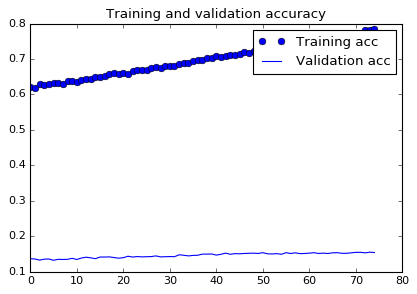

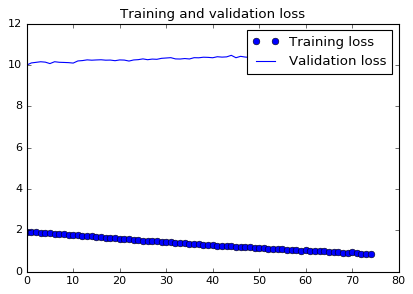

In [31]:
%matplotlib inline
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()